In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
full_path = '/Users/tonny/Desktop/tata_thesis_stage/dvl/2024-04-04_DVL1_test_data_for_refit.csv'
dvl1 = pd.read_csv(full_path, delimiter=',')
dvl1 = dvl1[dvl1['r_value'] != 0]

In [3]:
def map_steel_family(df):

    family_mapping = {
        # AHSS family
        '2F63': 'AHSS',
        '2F95': 'AHSS',
        '2Q91': 'AHSS',
        '3F63': 'AHSS',
        
        # CMn family
        '110E': 'CMn', '110F': 'CMn', '110H': 'CMn', '112H': 'CMn', 
        '112L': 'CMn', '114E': 'CMn', '116L': 'CMn', '125C': 'CMn',
        '126C': 'CMn', '126L': 'CMn', '180L': 'CMn', '180N': 'CMn',
        '184L': 'CMn', '184M': 'CMn', '186C': 'CMn', '187L': 'CMn',
        '180G': 'CMn', '111C': 'CMn', '114C': 'CMn', '114H': 'CMn',
        '121L': 'CMn', '1T46': 'CMn', '1T36': 'CMn', '1T86': 'CMn',
        '1S38': 'CMn', '1S42': 'CMn', '1T32': 'CMn', '1T80': 'CMn',
        '1T82': 'CMn', '1T34': 'CMn', '110B': 'CMn', '1P65': 'CMn',
        '184K': 'CMn', '1N47': 'CMn', '1N57': 'CMn', '123L': 'CMn',
        '115H': 'CMn', '1T44': 'CMn', '1T84': 'CMn', '1T94': 'CMn', 
        '115E': 'CMn', '1P85': 'CMn', 
        
        # HSLA family
        '1N80': 'HSLA', '1N31': 'HSLA', '1N60': 'HSLA', '1N61': 'HSLA',
        '1N81': 'HSLA', '1N91': 'HSLA', '1N84': 'HSLA', '1N64': 'HSLA',
        '1N94': 'HSLA', '1N32': 'HSLA', '1N33': 'HSLA', '1N62': 'HSLA',
        '1N63': 'HSLA', '1N82': 'HSLA', '1N83': 'HSLA', '1N92': 'HSLA',
        '1N93': 'HSLA', '1N36': 'HSLA', '1N37': 'HSLA', '1N66': 'HSLA',
        '1N67': 'HSLA', '1N86': 'HSLA', '1N87': 'HSLA', '1N96': 'HSLA',
        '1N97': 'HSLA', '1N38': 'HSLA', '1N39': 'HSLA', '1N68': 'HSLA',
        '1N69': 'HSLA', '1N88': 'HSLA', '1N98': 'HSLA', '1N99': 'HSLA',
        '3N73': 'HSLA', '3N73': 'HSLA',
        
        # IF family
        '514Z': 'IF', '515M': 'IF', '581G': 'IF', '590Q': 'IF',
        '590Z': 'IF', '591M': 'IF', '594Q': 'IF', '594Z': 'IF',
        '595M': 'IF', '542P': 'IF', '543P': 'IF', '544P': 'IF',
        '545P': 'IF', '540Z': 'IF', '541M': 'IF', '54AE': 'IF',
        '561P': 'IF', '592P': 'IF', '593P': 'IF', '598P': 'IF',
        '599P': 'IF', '59AD': 'IF', '552V': 'IF', '553V': 'IF',
        '589L': 'IF', '59TM': 'IF', '55AV': 'IF'
    }
    
    df_copy = df.copy()
    
    # Map steel family on the copy
    df_copy['steel_family'] = df_copy['steel_grade'].map(family_mapping)
    
    return df_copy

In [4]:
def remove_outliers(df):
    Q1 = df['r_value'].quantile(0.10)
    Q3 = df['r_value'].quantile(0.90)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df['r_value'] >= lower_bound) & (df['r_value'] <= upper_bound)]

In [5]:
path = '/Users/tonny/Desktop/tata_thesis_stage/MDC_Data_Descriptions_MeCoMeP-r-value.xlsx'
desc = pd.read_excel(path, sheet_name=3)

tmp = desc[(desc['model'] != 'n') & (desc['Table Name'] == 'mecomep_dv21') 
             & ((desc['Input Type'] == 'Actual - Measurement or Count') | (desc['Input Type'] == 'Prediction - Calculation'))]
features_selected = tmp[['Attribute Name', 'Input Type']]

existing_columns = [col for col in features_selected['Attribute Name'] if col in dvl1.columns]
dvl1_selected = dvl1[existing_columns+['r_value', 'steel_grade']]

/opt/anaconda3/lib/python3.11/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Data Validation extension is not supported and will be removed
  for idx, row in parser.parse():


In [6]:
nan_cols = dvl1_selected.isna().sum().sort_values(ascending=False)
nan_cols = nan_cols[nan_cols > 0] #columns with no nan are not relevant
cols_to_drop = nan_cols[nan_cols > 100].index.tolist()
dvl1_selected = dvl1_selected.drop(cols_to_drop, axis=1)
dvl1_selected.dropna(inplace=True)

In [7]:
corr_threshold = 0.2

corr = dvl1_selected.drop(['steel_grade'], axis=1).corr()['r_value'].abs()
selected_features = corr[abs(corr) >= corr_threshold].index.tolist()

print(f'dropped {len(dvl1_selected.columns) - len(selected_features)} columns')

dropped 24 columns


In [8]:
dvl1_selected = dvl1_selected[selected_features+['steel_grade']]
counts = dvl1_selected['steel_grade'].value_counts()
filtered_values = counts[counts >= 5].index
dvl1_selected = dvl1_selected[dvl1_selected['steel_grade'].isin(filtered_values)]
dvl1_selected = map_steel_family(dvl1_selected).drop(['steel_grade'], axis=1)
dvl1_selected = dvl1_selected.groupby('steel_family').apply(remove_outliers).reset_index(drop=True)

dvl1_selected

,cold_roll_reduction,elong_tl_pct,elong_tm_pct,gauge_f1,gauge_f2,gauge_f3,gauge_f4,gauge_f5,gauge_f6,gauge_f7,...,tension_tm_exit_mpa,time_inter_f1,time_inter_f2,time_inter_f3,time_inter_f4,time_inter_f5,time_inter_f6,time_inter_f7,r_value,steel_family
0,66.97,2.0,16.0,24.529786,16.663215,11.979636,9.008755,6.573885,5.513293,4.56455,...,81.0,38.100,3.690,2.400,1.710,1.300,1.050,0.850,1.15,CMn
1,67.88,2.0,0.0,26.053005,18.053067,12.849053,9.586975,7.760840,6.249673,4.72489,...,118.0,39.484,4.328,2.860,2.009,1.481,1.179,0.862,1.05,CMn
2,67.90,2.0,16.0,24.351294,16.750388,12.294898,9.102001,6.660000,5.530000,4.70891,...,81.0,44.838,4.530,2.960,2.029,1.516,1.229,1.005,1.15,CMn
3,72.38,2.0,16.0,21.690000,12.760000,8.450000,5.960000,4.410000,3.450000,2.90239,...,90.0,72.496,3.640,2.051,1.351,0.940,0.684,0.542,1.05,CMn
4,72.38,2.0,16.0,20.780000,12.730000,8.530000,5.900000,4.410000,3.440000,2.89543,...,90.0,72.272,3.531,2.006,1.330,0.934,0.687,0.545,1.05,CMn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15591,78.13,1.0,15.0,26.590000,17.980000,12.760000,9.440000,7.160000,5.550000,3.80039,...,36.0,68.653,2.569,1.715,1.213,0.882,0.673,0.514,1.50,IF
15592,73.90,1.0,13.0,28.973028,20.959475,15.100574,11.654747,9.185976,7.139899,5.76871,...,47.0,34.770,2.870,2.030,1.470,1.120,0.870,0.700,1.65,IF
15593,80.32,1.0,15.0,26.670000,17.900000,12.060000,8.490000,6.530000,5.120000,4.37135,...,45.0,45.712,3.167,2.076,1.411,0.996,0.755,0.582,2.20,IF
15594,80.32,1.0,15.0,27.028830,18.710170,12.928046,9.371886,7.225700,5.603521,4.39936,...,49.0,35.765,3.247,2.170,1.481,1.049,0.790,0.610,2.15,IF


In [9]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Split first to avoid data leakage
train_df, test_df = train_test_split(dvl1_selected, test_size=0.2, random_state=42)

# Scale the training set
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train_df.drop(['steel_family'], axis=1))
train_scaled_df = pd.DataFrame(train_scaled, columns=train_df.drop(['steel_family'], axis=1).columns)
train_scaled_df['steel_family'] = train_df['steel_family'].reset_index(drop=True)

# Scale the testing set using the scaler fitted on the training set
test_scaled = scaler.transform(test_df.drop(['steel_family'], axis=1))
test_scaled_df = pd.DataFrame(test_scaled, columns=test_df.drop(['steel_family'], axis=1).columns)
test_scaled_df['steel_family'] = test_df['steel_family'].reset_index(drop=True)

In [10]:
from sklearn.model_selection import GridSearchCV
from tqdm import tqdm

def optimize_hyperparameters(X_train, y_train):

    param_grid = {
        'learning_rate': [0.01, 0.1, 0.3],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'n_estimators': [100, 200, 300]
    }
    
    grid_search = GridSearchCV(
        estimator=XGBRegressor(random_state=42),
        param_grid=param_grid,
        cv=5,  # 5-fold cross-validation
        scoring='neg_mean_squared_error',
        n_jobs=-1  # Use all available cores
    )
    
    grid_search.fit(X_train, y_train)
    
    return {
        'best_params': grid_search.best_params_,
        'best_estimator': grid_search.best_estimator_,
        'best_score': -grid_search.best_score_  # Convert back to MSE
    }

def train_optimized_family_models(df):
    # Dictionary to store optimized models
    optimized_models = {}
    
    # Get unique families with progress bar
    families = list(df['steel_family'].unique())
    
    for family in tqdm(families, desc="Optimizing Models", unit="family"):
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Optimize hyperparameters
        optimization_results = optimize_hyperparameters(X_train, y_train)
        
        # Train final model with best parameters
        best_model = optimization_results['best_estimator']
        best_model.fit(X_train, y_train)
        
        # Evaluate model
        y_pred_train = best_model.predict(X_train)
        y_pred_test = best_model.predict(X_test)
        
        optimized_models[family] = {
            'model': best_model,
            'best_params': optimization_results['best_params'],
            'best_score': optimization_results['best_score'],
            'train_mse': mean_squared_error(y_train, y_pred_train),
            'test_mse': mean_squared_error(y_test, y_pred_test),
            'train_r2': r2_score(y_train, y_pred_train),
            'test_r2': r2_score(y_test, y_pred_test)
        }
    
    return optimized_models

In [11]:
# # Run optimization
# optimized_family_models = train_optimized_family_models(train_scaled_df)

# for family, model_info in optimized_family_models.items():
#     print(f"Family: {family}")
#     print(f"Best Parameters: {model_info['best_params']}")
#     print(f"Best CV Score (MSE): {model_info['best_score']}")
#     print(f"Test MSE: {model_info['test_mse']}")
#     print(f"Test R2: {model_info['test_r2']}")

# Family: CMn
# Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
# Best CV Score (MSE): 0.045211356766061396
# Test MSE: 0.04395562330409197
# Test R2: 0.6607347578705376
# Family: IF
# Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.6}
# Best CV Score (MSE): 0.0893883448978633
# Test MSE: 0.09332743411302731
# Test R2: 0.5409860482170444
# Family: HSLA
# Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
# Best CV Score (MSE): 0.022972327296782346
# Test MSE: 0.022752941585018747
# Test R2: 0.745014701071617

Optimizing Models: 100%|██████████| 3/3 [08:09<00:00, 163.17s/family]

Family: CMn
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 7, 'min_child_weight': 3, 'n_estimators': 100, 'subsample': 1.0}
Best CV Score (MSE): 0.045211356766061396
Test MSE: 0.04395562330409197
Test R2: 0.6607347578705376
Family: IF
Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 300, 'subsample': 0.6}
Best CV Score (MSE): 0.08938834489786333
Test MSE: 0.09332743411302731
Test R2: 0.5409860482170444
Family: HSLA
Best Parameters: {'colsample_bytree': 0.6, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 3, 'n_estimators': 200, 'subsample': 1.0}
Best CV Score (MSE): 0.022972327296782346
Test MSE: 0.022752941585018747
Test R2: 0.745014701071617


In [13]:
optimized_family_models_grid = {'CMn': {'model': XGBRegressor(
               colsample_bytree=0.6, learning_rate=0.1, max_depth=7,
               min_child_weight=3, n_estimators=100, subsample=1.0, random_state=42),
  'best_params': {'colsample_bytree': 0.6,
   'learning_rate': 0.1,
   'max_depth': 7,
   'min_child_weight': 3,
   'n_estimators': 100,
   'subsample': 1.0},
  'best_score': 0.045211356766061396,
  'train_mse': 0.0038391143645356137,
  'test_mse': 0.04395562330409197,
  'train_r2': 0.9710033196421187,
  'test_r2': 0.6607347578705376},
 'IF': {'model': XGBRegressor(
               colsample_bytree=0.8,learning_rate=0.01, max_depth=7,
               min_child_weight=5, n_estimators=300, subsample=0.6, random_state=42),
  'best_params': {'colsample_bytree': 0.8,
   'learning_rate': 0.01,
   'max_depth': 7,
   'min_child_weight': 5,
   'n_estimators': 300,
   'subsample': 0.6},
  'best_score': 0.08938834489786333,
  'train_mse': 0.05223781140434004,
  'test_mse': 0.09332743411302731,
  'train_r2': 0.7280153700717125,
  'test_r2': 0.5409860482170444},
 'HSLA': {'model': XGBRegressor(
               colsample_bytree=0.6, learning_rate=0.1, max_depth=5,
               min_child_weight=3, n_estimators=200, random_state=42),
  'best_params': {'colsample_bytree': 0.6,
   'learning_rate': 0.1,
   'max_depth': 5,
   'min_child_weight': 3,
   'n_estimators': 200,
   'subsample': 1.0},
  'best_score': 0.022972327296782346,
  'train_mse': 0.005581421848799033,
  'test_mse': 0.022752941585018747,
  'train_r2': 0.9392633553365833,
  'test_r2': 0.745014701071617}}

In [24]:
def train_optimized_models(df, optimized_models_dict):
    trained_models = {}
    for model_name, model_config in optimized_models_dict.items():
        # Filter data for the specific steel family
        family_data = df[df['steel_family'] == model_name]
        
        # Separate features and target
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Extract the best parameters
        best_params = model_config['best_params']
        
        # Create and train the model
        model = XGBRegressor(**best_params)
        model.fit(X_train, y_train)
        
        # Store the model with additional information
        trained_models[model_name] = {
            'model': model,
            'test_r2': model_config['test_r2'],
            'test_mse': model_config['test_mse']
        }
    
    return trained_models

In [25]:
trained_models = train_optimized_models(test_scaled_df, optimized_family_models_grid)

In [26]:
def plot_predicted_vs_actual(optimized_models, df):
    plt.figure(figsize=(15, 5 * len(optimized_models)))
    
    for i, (family, model_info) in enumerate(optimized_models.items(), 1):
        plt.subplot(len(optimized_models), 1, i)
        
        # Recreate train/test split
        family_data = df[df['steel_family'] == family]
        X = family_data.drop(['steel_family', 'r_value'], axis=1)
        y = family_data['r_value']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        # Predict
        y_pred_test = model_info['model'].predict(X_test)
        
        # Plot
        plt.scatter(y_test, y_pred_test, alpha=0.7)
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
        plt.title(f'{family} - Predicted vs Actual R-Value')
        plt.xlabel('Actual R-Value')
        plt.ylabel('Predicted R-Value')
        
        # Annotate with R² and MSE
        plt.text(0.05, 0.95, 
                 f"Test R²: {model_info['test_r2']:.4f}\n" +
                 f"Test MSE: {model_info['test_mse']:.4f}", 
                 transform=plt.gca().transAxes, 
                 verticalalignment='top')
    
    plt.tight_layout()
    plt.show()

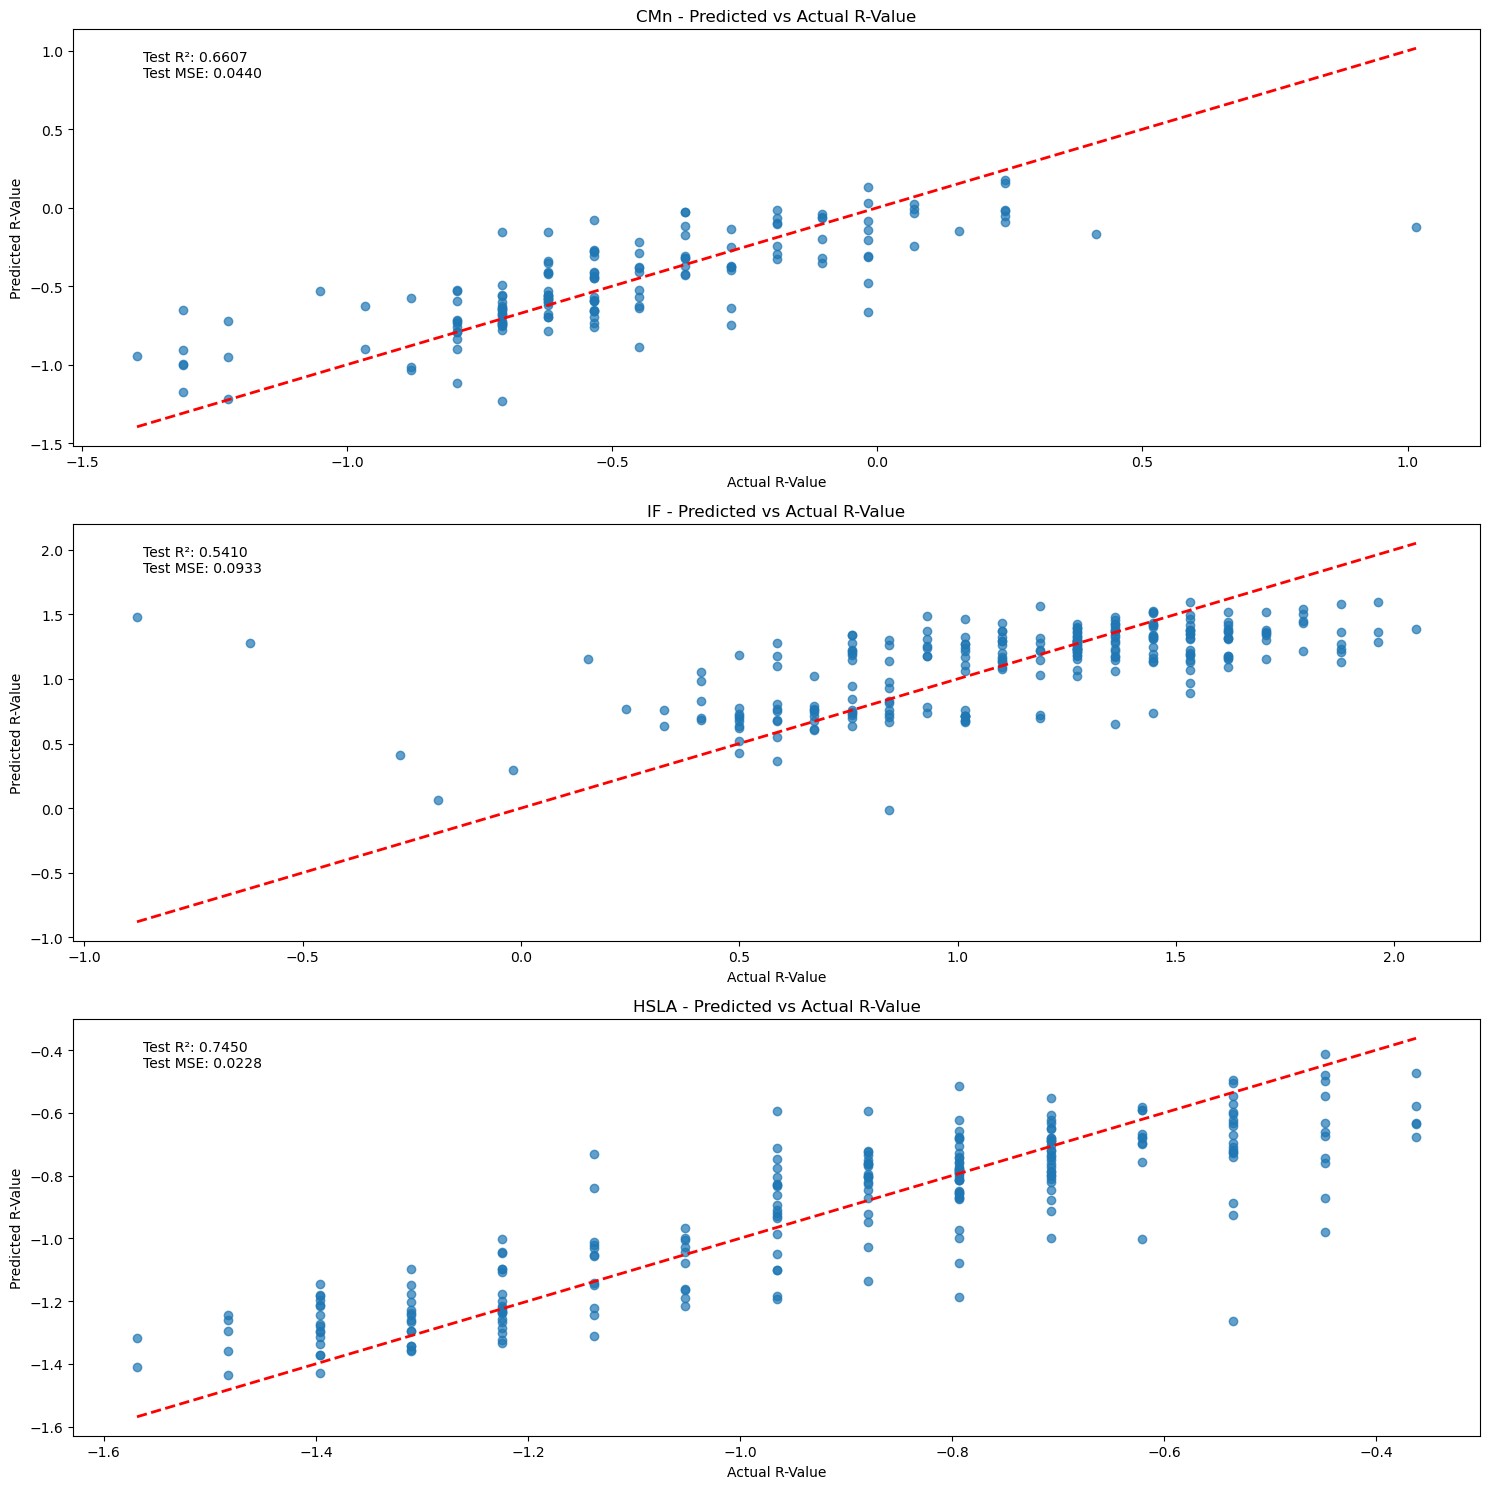

In [27]:
plot_predicted_vs_actual(trained_models, test_scaled_df)